# The 3 datasets that make up the live Parking Sensors data 

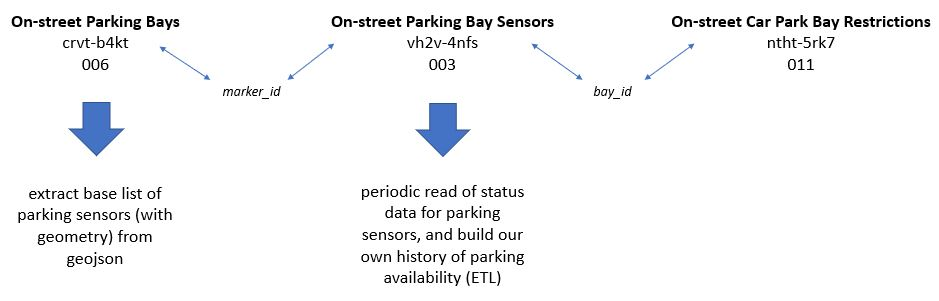

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from shapely.geometry import Polygon
from sodapy import Socrata
from d2i_tools import genPSdata, getCurrentPSstatus, timeIntStats, filterById, geoPolyClip, geoCirFilter

apptoken = os.environ.get("SODAPY_APPTOKEN")
domain = "data.melbourne.vic.gov.au"

client = Socrata(domain, apptoken)

## [01] Randomly generate history of parking status data mimic real data

In [2]:
# specify end date time, time interval of records, periods (number of time intervals)
# first bay id, last bay id, and a drop rate (between 0 and 1) of how much to drop in dfg

dfgh = genPSdata("2021-09-02 15:01:23", "15min", (3*30*24*4), 995, 4502, dropRate=0.7)
print(f"\nshape of artificially random generated data is {dfgh.shape}")
dfgh.head(3)

Generated 9092736 records between 2021-06-04 15:16:23 and 2021-09-02 15:01:23
(with drop rate of 0.7, to simulate missing status records in real data).
There are 8640 time periods over 91 days
(frequency of time period = 15min).

shape of artificially random generated data is (9092736, 3)


,bay_id,db_read_time,status
0,1003,2021-06-04 15:16:23,Present
1,2692,2021-06-04 15:16:23,Present
2,2111,2021-06-04 15:16:23,Unoccupied


In [35]:
# check how many bays in this time interval
(dfgh['db_read_time']=="2021-06-04 15:16:23").sum()

1020

## [02] Read in a short history of some real data

In [65]:
dfrh = pd.read_csv("datasets/003_vh2v-4nfs__bufferred.csv")
print(f"shape of read in historical data is {dfrh.shape}")
dfrh.head(3)

shape of read in historical data is (83096, 3)


,st_marker_id,status,db_read_time
0,15197S,Present,2021-08-27 19:20:18.571722
1,15199S,Unoccupied,2021-08-27 19:20:18.571722
2,13040N,Unoccupied,2021-08-27 19:20:18.571722


In [20]:
# check how many bays in this time interval
(dfrh['db_read_time']=="2021-08-27 19:20:18.571722").sum()

1035

## [03] Show current parking sensors status statistics

In [62]:
r1 = client.get_all('vh2v-4nfs')
dfrc = pd.DataFrame.from_dict(r1)

getCurrentPSstatus(dfrc)

Number of current status records of parking sensors read : 1041
Number of current available parking bays : 254 (24.4% of total)
Number of current unavailable parking bays : 787 (75.6% of total)


(1041, 254, 787)

## [04] Turn historical parking status data into resampled pivoted data

shape of resampled pivoted data is (18, 2)


,Present,Unoccupied
time_interval,,
2021-08-27 21:00:00,237,789
2021-08-27 22:00:00,231,804
2021-08-27 23:00:00,228,804


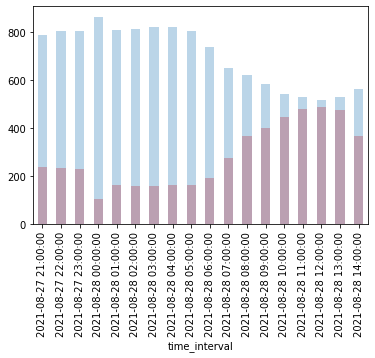

In [64]:
# use the little real logged historical data in dfrh to try shorter periods
# bin specifies resampling frequency ("15min", "1H, "1D", "1W", "1M")
# bin_stat specifies resampled statistic for each resampled time interval

startdt = "2021-08-27 21:00:00"
enddt = "2021-08-28 15:00:00"

dfts1 = timeIntStats(dfrh, startdt, enddt, bin="1H", bin_stat="min")
print(f"shape of resampled pivoted data is {dfts1.shape}")

dfts1.Present.plot(kind='bar',color='red', alpha=0.3)
dfts1.Unoccupied.plot(kind='bar',alpha=0.3)

dfts1.head(3)

shape of resampled pivoted data is (32, 2)


,Present,Unoccupied
time_interval,,
2021-07-28,524.0,521.5
2021-07-29,526.5,525.5
2021-07-30,524.0,526.5


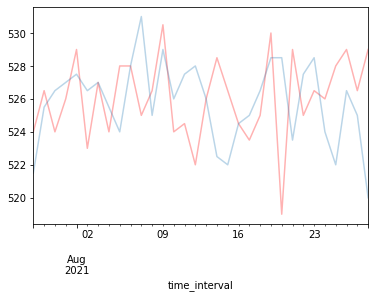

In [4]:
# use more abundant randomly generated data in dfgh to try out longer periods

startdt = "2021-07-28 21:00:00"
enddt = "2021-08-28 15:00:00"

dfts2 = timeIntStats(dfgh, startdt, enddt, bin="1D", bin_stat="median")
print(f"shape of resampled pivoted data is {dfts2.shape}")

dfts2.Present.plot(kind='line',color='red', alpha=0.3)
dfts2.Unoccupied.plot(kind='line',alpha=0.3)

dfts2.head(3)

## [05] Filter data with id(s)

In [70]:
# the id_lst can be the result of a geo-filter
# the filtered data then be used by other functions

id_lst = ["13040N", "15199S", "13040N"]

df_filtered = filterById(id_lst, "st_marker_id", dfrh)
print(f"shape of filtered data is {df_filtered.shape}")

df_filtered.head(3)

shape of filtered data is (105, 3)


,st_marker_id,status,db_read_time
1,15199S,Unoccupied,2021-08-27 19:20:18.571722
2,13040N,Unoccupied,2021-08-27 19:20:18.571722
1036,15199S,Unoccupied,2021-08-27 19:35:22.087833


## [06] Geo-filter Parking Bays with a polygon

In [77]:
# set polygon to geo-filter geometries that are within
lat1, lon1 = -37.81192120679105, 144.95628148775384
lat2, lon2 = -37.81036832849929, 144.9616049327078
lat3, lon3 = -37.806134720609734, 144.95972125218563
lat4, lon4 = -37.805700253666316, 144.95569649380283
lat5, lon5 = -37.80921289191341, 144.95508810009383
polygon = Polygon([(lon1, lat1), (lon2, lat2), (lon3, lat3), (lon4, lat4), (lon5, lat5)])

# read in parking sensors data and geometries from our extracted geojson base list
gdf = geopandas.read_file("datasets/onStreetParkingBays_baselist_bayCentroid.geojson")
print(f"shape of read in base list is {gdf.shape}\n")
print(gdf.head(3))

gdf_geofiltered = geoPolyClip(gdf, polygon)
print(f"\n\nshape of geo-filtered gdf is {gdf_geofiltered.shape}\n")
print(gdf_geofiltered.head(3))
gdf_geofiltered.to_file("datasets/geofiltered_data.geojson", driver="GeoJSON")

shape of read in base list is (5895, 7)

  rd_seg_id marker_id                                         rd_seg_dsc  \
0     23247     C5010  Queen Street between Therry Street and Victori...   
1     23247     4999W  Queen Street between Therry Street and Victori...   
2     20173     1114E  Queen Street between Little Collins Street and...   

        lati        long   area_m2                     geometry  
0 -37.806447  144.958202  9.388646  POINT (144.95820 -37.80645)  
1 -37.806586  144.958043  8.148094  POINT (144.95804 -37.80659)  
2 -37.815324  144.960975  6.970730  POINT (144.96098 -37.81532)  


shape of geo-filtered gdf is (420, 7)

  rd_seg_id marker_id                                         rd_seg_dsc  \
0     23247     C5010  Queen Street between Therry Street and Victori...   
1     23247     4999W  Queen Street between Therry Street and Victori...   
4     23247     4995W  Queen Street between Therry Street and Victori...   

        lati        long   area_m2          

## [07] Geo filter marker ids (of parking bays) using Miriam's circle

In [2]:
# specify Miriam's filtering circle
pin = (-37.812389676018476, 144.95817254056357)  # centre of Little Lonsdale St (btw William St & Queen St)
radius_m = 100  # radius in metres

# load parking bays base list as gdf
gdf_baselist = geopandas.read_file("datasets/onStreetParkingBays_baselist_bayCentroid.geojson")  # base list of 5895 marker ids
print(f"shape of base list data is {gdf_baselist.shape}")

# filter base list with Miriam's circle
lst_marker_ids = geoCirFilter(gdf_baselist,pin,radius_m)

# use fitlered list of marker ids to get geopandas records to visualise
gdf_filtered = filterById(lst_marker_ids, "marker_id", gdf_baselist)
print(f"shape of circle filtered data is {gdf_filtered.shape}")

# save filtered geopandas records to geojson .. so it can be viewed on map
gdf_filtered.to_file("datasets/circledData.geojson", driver="GeoJSON")

shape of base list data is (5895, 7)
shape of circle filtered data is (19, 7)
